# **LocalGuide Chat-bot model**

Fine-tuning T5 model to my local dataset to create a local guide chatbot

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
import sklearn
import transformers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
from transformers import T5Tokenizer

Here I used sythentic dataset the I generated using some various website that has Information about rwanda and used a python script to generate this csv file of q&a

In [3]:
# Load the dataset
df = pd.read_csv('rwanda_qa_cleaned.csv')

df.head()

,domain,question,answer
0,tourism,Best place to see mountain gorillas?,Volcanoes National Park in Musanze offers gori...
1,tourism,Can you tell me best place to see mountain gor...,Volcanoes National Park in Musanze offers gori...
2,tourism,What's special about Nyungwe Forest in Rwanda?,Home to chimpanzees and East Africa's only can...
3,tourism,What's special about Nyungwe Forest?,Home to chimpanzees and East Africa's only can...
4,tourism,Can I do a safari in Rwanda?,"Yes, Akagera National Park has lions, elephant..."


In [4]:
df.describe()

,domain,question,answer
count,418,418,418
unique,13,417,333
top,history,Where would I find traditional courts?,Kigali Serena and Cercle Sportif have public p...
freq,54,2,4


# **Exprolatory Data Analysis**

In [5]:
# Checking for missing values
df.isnull().sum()

,0
domain,0
question,0
answer,0


In [6]:
# Checking for duplicates and handling them
print(f'There are {df.duplicated().sum()} duplicate rows')

df = df.drop_duplicates()

print(f'There are {df.duplicated().sum()} duplicate rows')

There are 1 duplicate rows
There are 0 duplicate rows


In [7]:
#Checking the shape
print("Shape:", df.shape)

Shape: (417, 3)


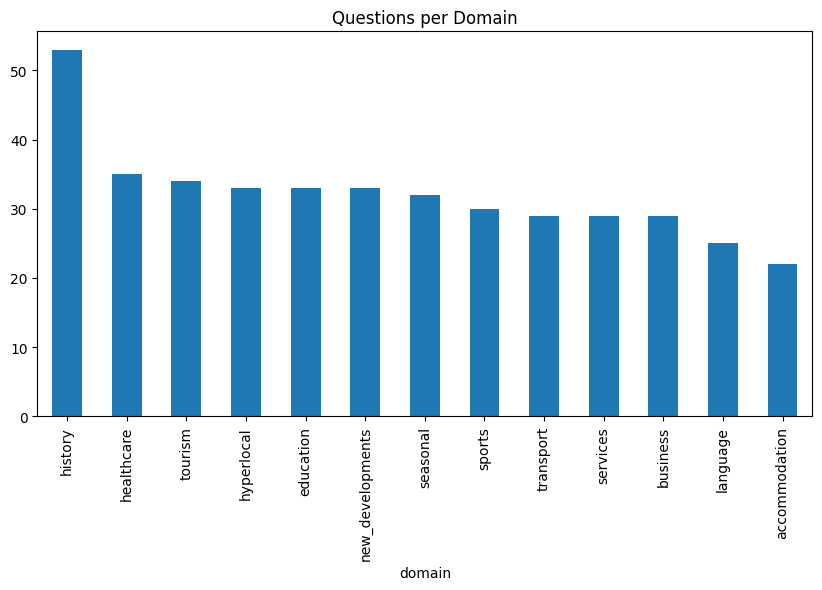

In [8]:
# Domain distribution
domain_counts = df['domain'].value_counts()
domain_counts.plot(kind='bar', title='Questions per Domain', figsize=(10, 5))
plt.show()

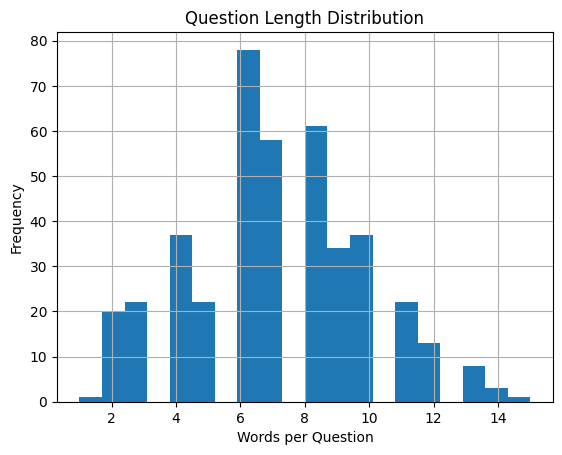

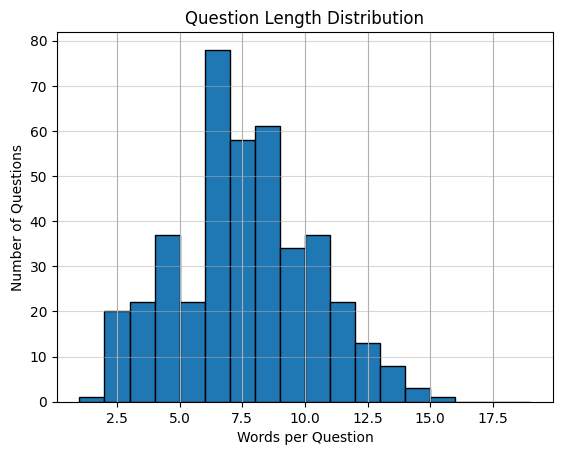

In [9]:
# Question length distribution
df['question_length'] = df['question'].apply(lambda x: len(str(x).split()))
df['question_length'].hist(bins=20)
plt.title('Question Length Distribution')
plt.xlabel('Words per Question')
plt.ylabel('Frequency')
plt.show()

# Add grid and adjust bins for clarity
df['question_length'].hist(bins=range(1, 20), edgecolor='black')
plt.title('Question Length Distribution')
plt.xlabel('Words per Question')
plt.ylabel('Number of Questions')
plt.grid(axis='y', alpha=0.5)
plt.show()

**Key insights**:


* Bars shrink drastically beyond ~8 words, indicating dataset rarely has verbose questions
* Almost no questions exceed 12 words
* Most questions are 2–6 words long



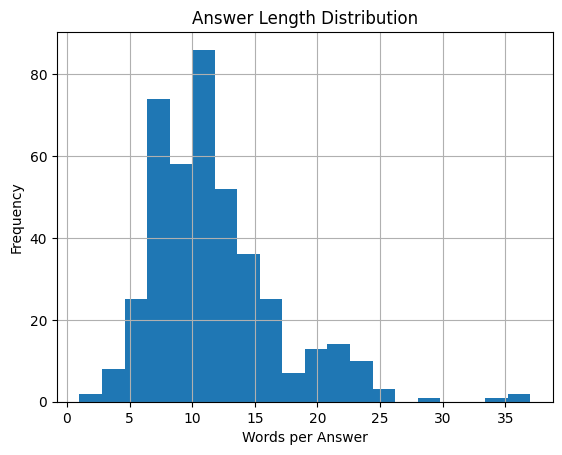

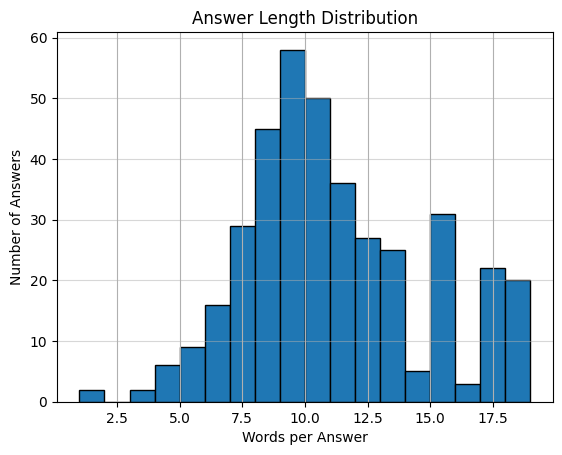

In [10]:
# Answer Length distribution
df['answer_length'] = df['answer'].apply(lambda x: len(str(x).split()))
df['answer_length'].hist(bins=20)
plt.title('Answer Length Distribution')
plt.xlabel('Words per Answer')
plt.ylabel('Frequency')
plt.show()

# Add grid and adjust bins for clarity
df['answer_length'].hist(bins=range(1, 20), edgecolor='black')
plt.title('Answer Length Distribution')
plt.xlabel('Words per Answer')
plt.ylabel('Number of Answers')
plt.grid(axis='y', alpha=0.5)
plt.show()

**Key insights**:


* Most answers are ≤10 words which means chatbot will prioritize clarity and brevity
* A sharp decline after ~12 words



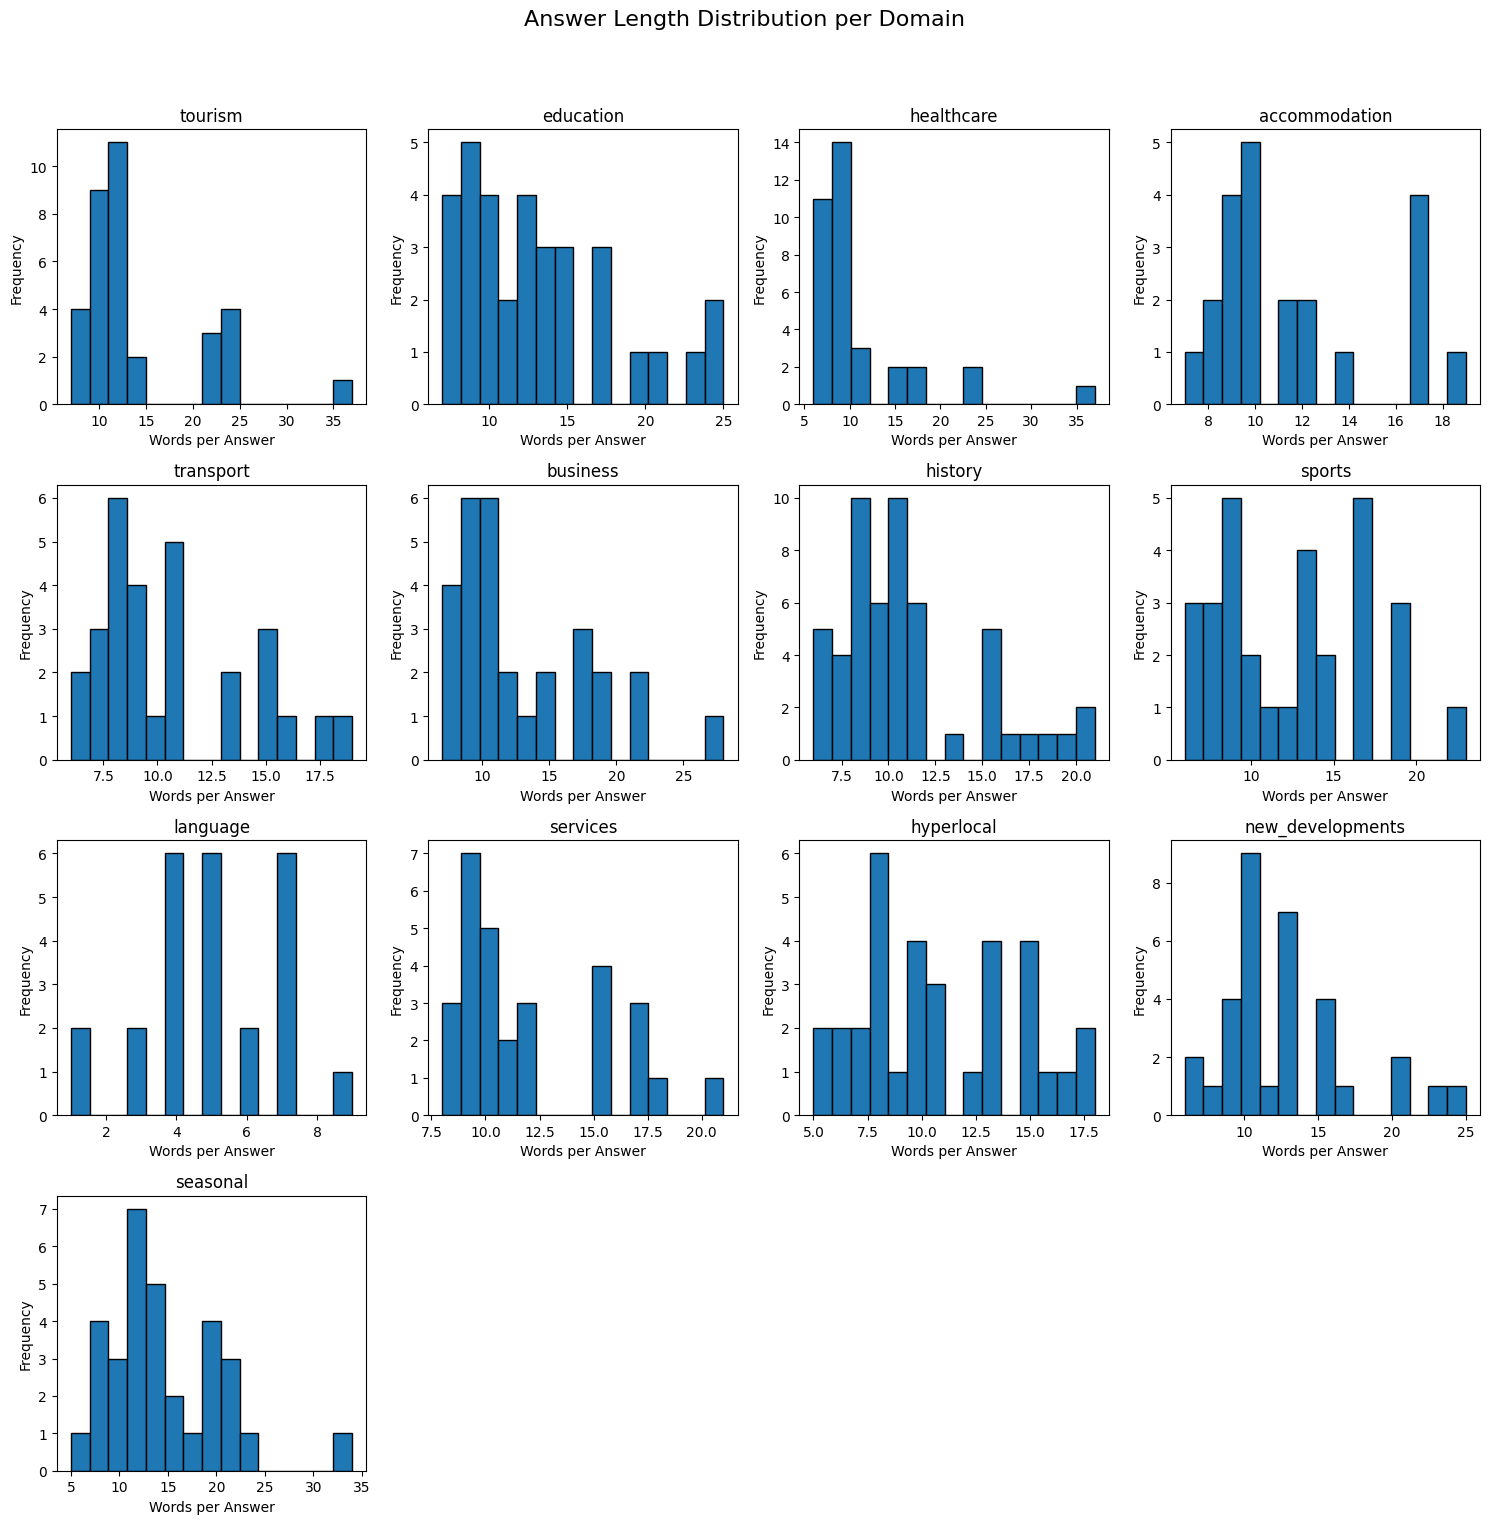

In [11]:
# Group by domain and plot answer lengths
domains = df['domain'].unique()
n_domains = len(domains)
n_cols = 4
n_rows = (n_domains + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

fig.suptitle('Answer Length Distribution per Domain', fontsize=16)

for i, domain in enumerate(domains):
    subset = df[df['domain'] == domain].copy()
    subset['answer_length'] = subset['answer'].str.split().str.len()

    axes[i].hist(subset['answer_length'], bins=15, edgecolor='black')
    axes[i].set_title(f'{domain}')
    axes[i].set_xlabel('Words per Answer')
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Key insights**:


* Most of the domains have <= 12 answers length
* Some have 35 answer word length, and doesn't go beyond that except one domain tourism



# **Preprocessing**

In [12]:
# Initialize T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-small")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [13]:
# Preprocessing function
class T5Preprocessor:
    def __init__(self, tokenizer_name='t5-small', max_input_length=64, max_target_length=32):
        self.tokenizer = T5Tokenizer.from_pretrained(tokenizer_name)
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def clean_text(self, text: str) -> str:
        text = str(text).lower().strip()
        text = re.sub(r'\s+', ' ', text)
        return text

    def format_row(self, row):
        input_text = f"question: {row['question_clean']} </s>"
        target_text = f"{row['answer_clean']} </s>"
        return pd.Series([input_text, target_text])

    def preprocess_dataframe(self, df: pd.DataFrame) -> pd.DataFrame:
        df['question_clean'] = df['question'].apply(self.clean_text)
        df['answer_clean'] = df['answer'].apply(self.clean_text)
        df[['input_text', 'target_text']] = df.apply(self.format_row, axis=1)
        return df[['input_text', 'target_text']]

    def tokenize_example(self, input_text, target_text):
        input_enc = self.tokenizer.encode_plus(
            input_text,
            max_length=self.max_input_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_enc = self.tokenizer.encode_plus(
            target_text,
            max_length=self.max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return input_enc, target_enc

In [14]:
# Using the modular for preprocessing
preprocessor = T5Preprocessor()

# Clean and format
processed_df = preprocessor.preprocess_dataframe(df)

# Preview a tokenized sample
sample_input, sample_target = preprocessor.tokenize_example(
    processed_df['input_text'].iloc[0],
    processed_df['target_text'].iloc[0]
)

print("Decoded input:", preprocessor.tokenizer.decode(sample_input['input_ids'][0]))
print("Decoded target:", preprocessor.tokenizer.decode(sample_target['input_ids'][0]))

Decoded input: question: best place to see mountain gorillas?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
Decoded target: volcanoes national park in musanze offers gorilla trekking.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [15]:
# Save processed CSV for training
processed_df.to_csv('processed_t5_rwanda_clean_data.csv', index=False)

In [16]:
df.head()

,domain,question,answer,question_length,answer_length,question_clean,answer_clean,input_text,target_text
0,tourism,Best place to see mountain gorillas?,Volcanoes National Park in Musanze offers gori...,6,8,best place to see mountain gorillas?,volcanoes national park in musanze offers gori...,question: best place to see mountain gorillas?...,volcanoes national park in musanze offers gori...
1,tourism,Can you tell me best place to see mountain gor...,Volcanoes National Park in Musanze offers gori...,10,10,can you tell me best place to see mountain gor...,volcanoes national park in musanze offers gori...,question: can you tell me best place to see mo...,volcanoes national park in musanze offers gori...
2,tourism,What's special about Nyungwe Forest in Rwanda?,Home to chimpanzees and East Africa's only can...,7,11,what's special about nyungwe forest in rwanda?,home to chimpanzees and east africa's only can...,question: what's special about nyungwe forest ...,home to chimpanzees and east africa's only can...
3,tourism,What's special about Nyungwe Forest?,Home to chimpanzees and East Africa's only can...,5,23,what's special about nyungwe forest?,home to chimpanzees and east africa's only can...,question: what's special about nyungwe forest?...,home to chimpanzees and east africa's only can...
4,tourism,Can I do a safari in Rwanda?,"Yes, Akagera National Park has lions, elephant...",7,11,can i do a safari in rwanda?,"yes, akagera national park has lions, elephant...",question: can i do a safari in rwanda? </s>,"yes, akagera national park has lions, elephant..."


**Tokenization Strategy**:
“We used the T5Tokenizer from Hugging Face, which uses SentencePiece-based subword tokenization. The questions were prepended with a task prefix ('question:') and tokenized with truncation and padding to consistent lengths (64 tokens for inputs, 32 for targets).”

**Cleaning & Normalization Steps**:
Removed extra whitespace and special characters.

Normalized punctuation (quotes, dashes).

Ensured all texts are trimmed and properly cased.

**Justification**:
“These preprocessing steps ensure the model receives well-structured, clean, and properly tokenized input—crucial for improving generalization and minimizing noise during fine-tuning.”

# **Training and Fine-tuning**

In [17]:
# Training and second preprocessing for id tokenization
from transformers import (
    T5ForConditionalGeneration,
    Trainer,
    TrainingArguments,
    DataCollatorForSeq2Seq,
)
from datasets import Dataset
import os
import torch


class T5Trainer:
    def __init__(
        self,
        model_name= "t5-small",
        max_input_length= 64,
        max_target_length= 32,
    ):
        self.model_name = model_name
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.trainer = None

    def load_dataset(self, csv_path: str):
        df = pd.read_csv(csv_path)[["input_text", "target_text"]].dropna()
        return Dataset.from_pandas(df)

    def preprocess(self, examples):
        model_inputs = self.tokenizer(
            examples["input_text"],
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
        )

        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                examples["target_text"],
                max_length=self.max_target_length,
                padding="max_length",
                truncation=True,
            )

        # Replace padding token IDs in labels with -100 so they're ignored in loss
        labels["input_ids"] = [
            [(tok if tok != self.tokenizer.pad_token_id else -100) for tok in seq]
            for seq in labels["input_ids"]
        ]
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    def prepare_data(self, dataset, val_ratio: 0.15):
        # Split ▶︎ map ▶︎ return two tokenized datasets
        train_test = dataset.train_test_split(test_size=val_ratio, seed=42)
        tokenized_train = train_test["train"].map(self.preprocess, batched=True)
        tokenized_val = train_test["test"].map(self.preprocess, batched=True)
        return tokenized_train, tokenized_val

    def train(
        self,
        train_dataset,
        val_dataset,
        output_dir= "t5_rwanda_model",
        epochs= 4,
        batch_size= 8,
        lr= 5e-5,
    ):
        training_args = TrainingArguments(
            output_dir=output_dir,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=lr,
            num_train_epochs=epochs,
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_strategy="epoch",
            weight_decay=0.01,
            save_total_limit=1,
            load_best_model_at_end=True,
            fp16=torch.cuda.is_available(),
        )

        data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer, model=self.model, label_pad_token_id=-100
        )

        self.trainer = Trainer(  # Store trainer instance
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
        )

        # Train the model
        self.trainer.train()

        # Save artifacts
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"Model and tokenizer saved to {output_dir}")

        # Plot training/validation losses
        self._plot_training_metrics()

        return self.trainer

    def _plot_training_metrics(self):
        """Plot training and validation loss curves"""
        if not hasattr(self, 'trainer'):
            raise ValueError("Trainer not initialized. Call train() first.")

        log_history = self.trainer.state.log_history
        train_loss = [log['loss'] for log in log_history if 'loss' in log]
        val_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, 'bo-', label='Training Loss')
        plt.plot(val_loss, 'r*-', label='Validation Loss')
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


## **Trials**

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/354 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/63 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1540919827.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: klakkent99 (klakkent99-alu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,4.881100,4.180200
2,4.276500,3.871119
3,4.047300,3.723520
4,3.920800,3.678257


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned


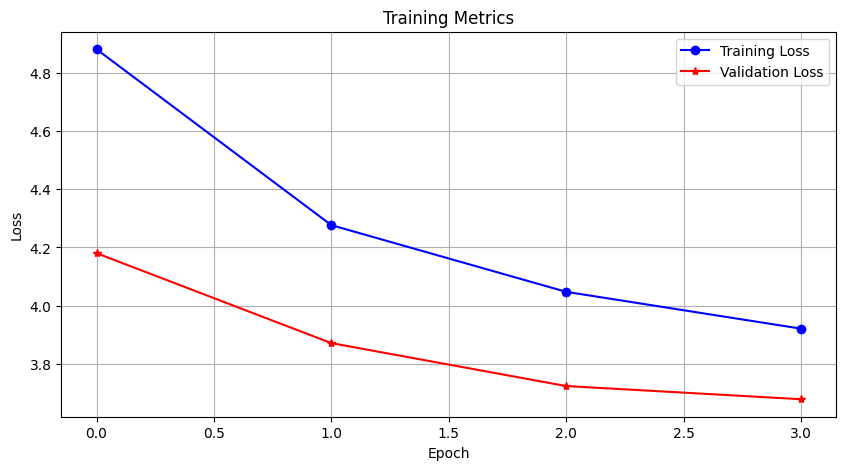

In [18]:
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.15)
# Store the returned trainer object
first_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned", epochs=4)

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

<ipython-input-16-2245579927>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,5.003300,4.291914
2,4.373900,3.939014
3,4.096500,3.768874
4,3.954300,3.657980
5,3.887900,3.588803
6,3.827500,3.562539


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_2


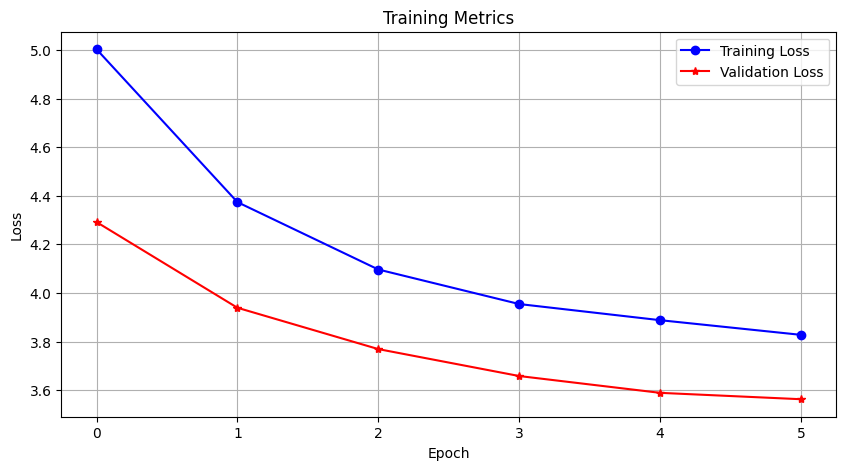

In [ ]:
# Second Trail - 6 epochs, 16 batchsize, and lr of 5e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
second_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_2", epochs=6, batch_size=16, lr=5e-5)

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

<ipython-input-16-2245579927>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,5.678800,5.350351
2,5.402400,5.070697
3,5.176000,4.869552
4,5.067500,4.757385
5,4.953300,4.680380
6,4.907200,4.630797
7,4.883500,4.602047
8,4.862300,4.591635


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_3


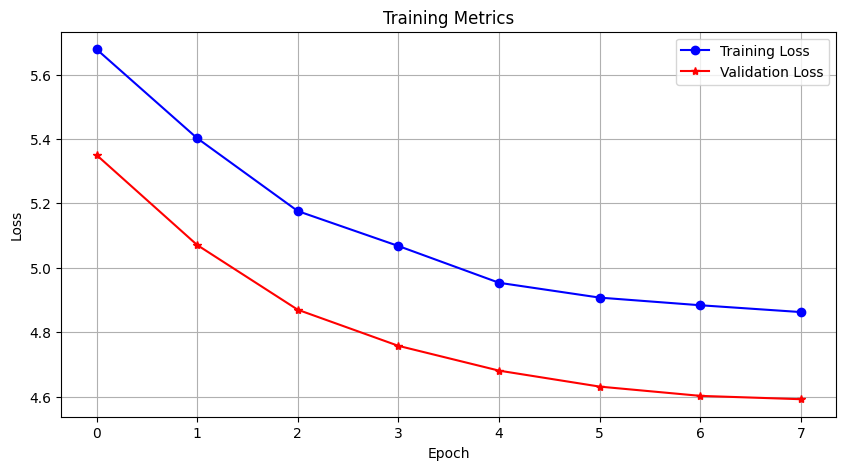

In [ ]:
# Third trail - epochs 8, batchsize 32, lr=1e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
third_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_3", epochs=8, batch_size=32, lr=1e-5)

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

<ipython-input-16-2245579927>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,5.231400,4.552835
2,4.638100,4.208284
3,4.379700,4.024470
4,4.217500,3.889874
5,4.069600,3.775019
6,3.976700,3.681518
7,3.898000,3.614684
8,3.830400,3.570356
9,3.813400,3.539498
10,3.777900,3.526844


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_4


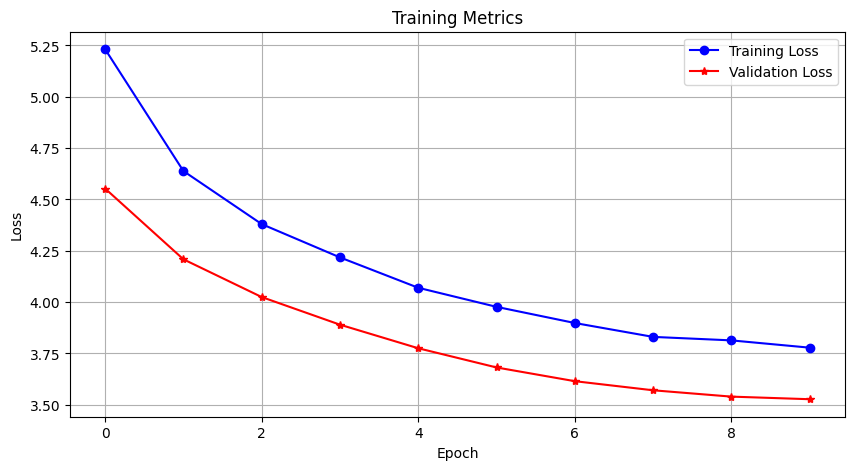

In [ ]:
#Fourth trail - 10 epochs, batchsize=32, lr=5e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
fourth_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_4", epochs=10, batch_size=32, lr=5e-5)

Map:   0%|          | 0/405 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/102 [00:00<?, ? examples/s]

<ipython-input-16-2245579927>:97: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,5.003000,4.287155
2,4.353200,3.926679
3,4.045400,3.680531
4,3.821700,3.480320
5,3.676100,3.344473
6,3.547300,3.238965
7,3.442500,3.162836
8,3.368100,3.111970
9,3.344000,3.081834
10,3.310900,3.070403


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_5


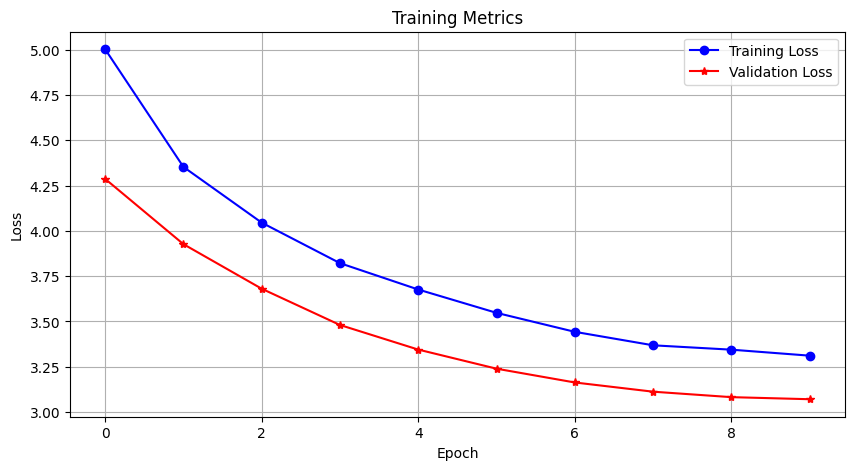

In [ ]:
#Fifth trial - epochs 10, batchsize  16, lr=5e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
fifth_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_5", epochs=10, batch_size=16, lr=5e-5)

Map:   0%|          | 0/333 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/84 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1540919827.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,4.908200,4.200335
2,4.230100,3.849164
3,3.963900,3.606001
4,3.733200,3.413485
5,3.552800,3.271216
6,3.417800,3.166637
7,3.322200,3.093532
8,3.260300,3.044647
9,3.217400,3.019160
10,3.204100,3.009169


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_6


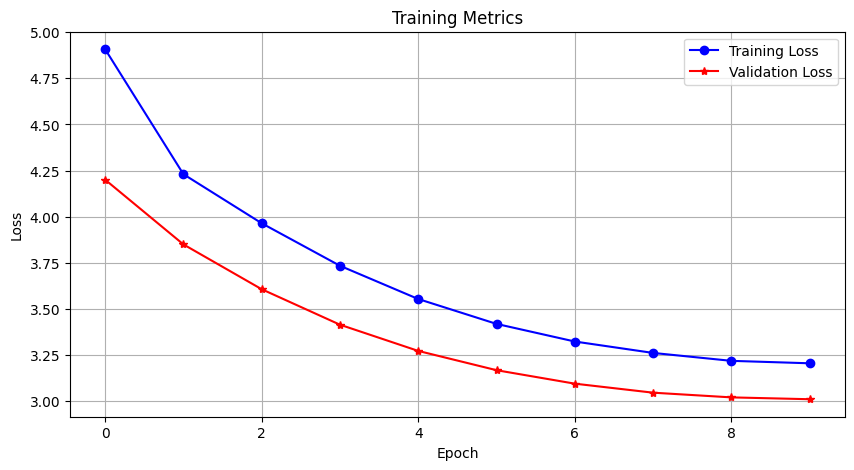

In [19]:
# Sixth trial - epochs 10, batchsize 8, lr=5e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
sixth_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_6", epochs=10, batch_size=8, lr=5e-5)

| Trial | Epochs | Batch Size | Learning Rate | Final Training Loss | Final Validation Loss |
| ----- | ------ | ---------- | ------------- | ------------------- | --------------------- |
| 1     | 4      | 8          | 5e-5          | 3.7634              | 3.4486                |
| 2     | 6      | 16         | 5e-5          | 3.8275              | 3.5625                |
| 3     | 8      | 32         | 1e-5          | 4.8623              | 4.5916                |
| 4     | 10     | 32         | 5e-5          | 3.7779              | 3.5268                |
| 5     | 10     | 16         | 5e-5          | 3.3109              | 3.0704                |
| 6     | 10     | 8          | 5e-5          | **2.9905**          | **2.7431**            |


Map:   0%|          | 0/333 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/84 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1540919827.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,4.899900,4.172367
2,4.195200,3.780617
3,3.864100,3.497344
4,3.582400,3.265154
5,3.364700,3.098935
6,3.189500,2.959294
7,3.039600,2.872037
8,2.933400,2.785059
9,2.832400,2.730988
10,2.755900,2.681423


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_7


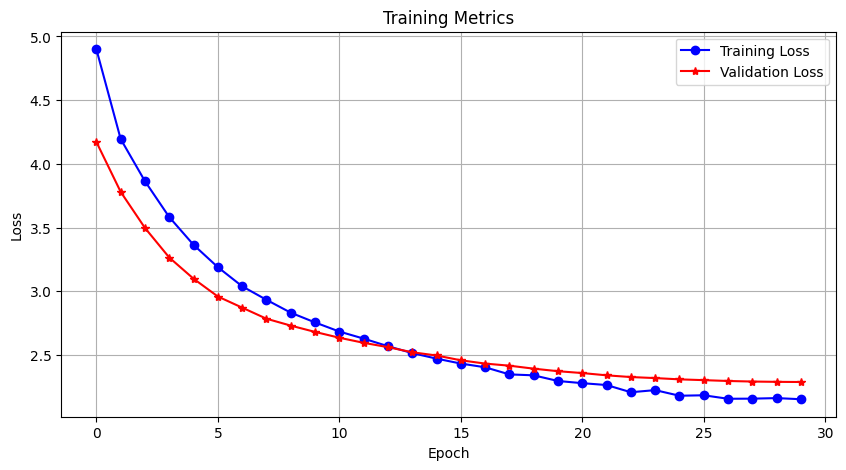

In [21]:
# 7th trial - epochs 30, batchsize 8, lr=5e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
seventh_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_7", epochs=30, batch_size=8, lr=5e-5)

Map:   0%|          | 0/333 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/84 [00:00<?, ? examples/s]

/tmp/ipython-input-17-1540919827.py:90: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  self.trainer = Trainer(  # Store trainer instance


Epoch,Training Loss,Validation Loss
1,4.902500,4.198528
2,4.201400,3.799237
3,3.883300,3.527881
4,3.624500,3.319876
5,3.432100,3.165411
6,3.277100,3.044622
7,3.150200,2.962849
8,3.061700,2.887464
9,2.980900,2.843812
10,2.929900,2.806488


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Model and tokenizer saved to t5_rwanda_finetuned_8


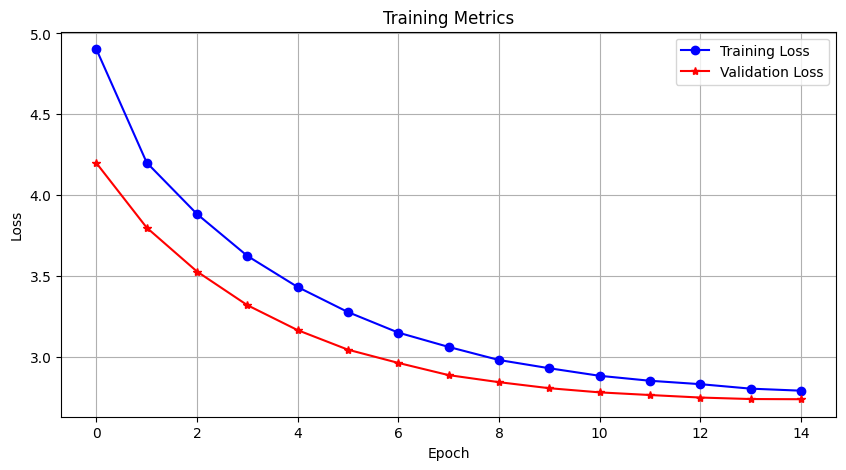

In [23]:
# 8th trial - epochs 15, batchsize 8, lr=5e-5
trainer = T5Trainer()
raw_ds = trainer.load_dataset("processed_t5_rwanda_clean_data.csv")
train_ds, val_ds = trainer.prepare_data(raw_ds, val_ratio=0.20)
# Store the returned trainer object
eigth_model_trainer = trainer.train(train_ds, val_ds, output_dir="t5_rwanda_finetuned_8", epochs=15, batch_size=8, lr=5e-5)

## **Combined**

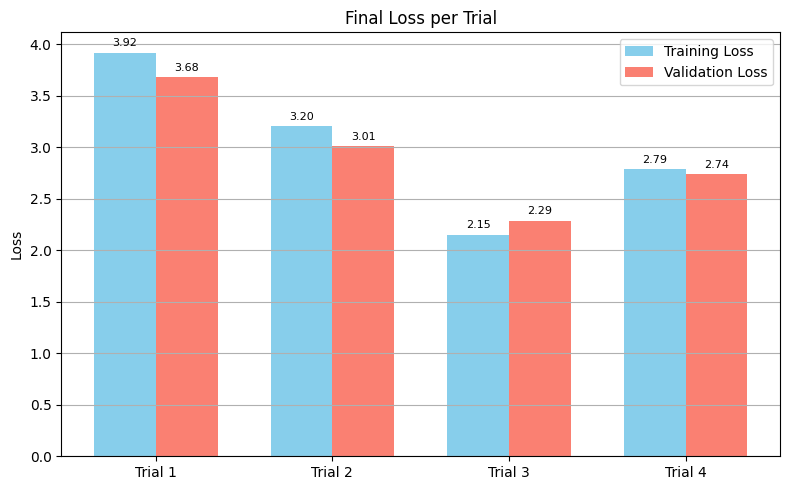

In [50]:
import matplotlib.pyplot as plt
import numpy as np


# Final losses
train_losses = [3.920800, 3.204100, 2.153300, 2.791200]
val_losses   = [3.678257, 3.009169, 2.288406, 2.738403]
labels = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4']

x = np.arange(len(labels))  # positions for bars
width = 0.35  # width of each bar

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, train_losses, width, label='Training Loss', color='skyblue')
bars2 = ax.bar(x + width/2, val_losses, width, label='Validation Loss', color='salmon')

# Add labels
ax.set_ylabel('Loss')
ax.set_title('Final Loss per Trial')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y')

# Optional: add value labels on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset text
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# **Performance metrics**

In [1]:
!pip install rouge-score bert-score evaluate --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.8 MB/s eta 0:00:00


In [42]:
# Evaluation with tuned decoding settings
from transformers import T5ForConditionalGeneration, T5Tokenizer
from evaluate import load as load_metric
from tqdm import tqdm
import torch, math, pandas as pd, numpy as np

# 1. Load model & tokenizer
model_dir = "t5_rwanda_finetuned"        # change if needed
model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5Tokenizer.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 2. Load validation split (20%)
df = pd.read_csv("processed_t5_rwanda_clean_data.csv")[["input_text", "target_text"]].dropna()
val_split = df.sample(frac=0.20, random_state=42)
inputs  = val_split["input_text"].tolist()
targets = val_split["target_text"].tolist()

# 3. Generate with tuned decoding params
def batch_generate(questions, batch=8, max_gen=32,
                   temperature=0.8, top_k=50, repetition_penalty=1.0):
    preds = []
    for i in tqdm(range(0, len(questions), batch)):
        enc = tokenizer(questions[i:i+batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=64).to(device)
        outs = model.generate(
            **enc,
            max_length=max_gen,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            repetition_penalty=repetition_penalty
        )
        preds.extend(tokenizer.batch_decode(outs, skip_special_tokens=True))
    return preds

preds = batch_generate(inputs)

# 4. BLEU
bleu = load_metric("bleu")
bleu_res = bleu.compute(predictions=preds,
                        references=[[ref] for ref in targets])

# 5. Perplexity
def calc_perplexity(model, tok, qs, ans, max_in=64, max_out=32):
    losses = []
    for q, a in zip(qs, ans):
        enc = tok(q, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_in).to(device)
        lab = tok(a, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_out).input_ids.to(device)
        with torch.no_grad():
            losses.append(model(**enc, labels=lab).loss.item())
    return math.exp(np.mean(losses))

ppl = calc_perplexity(model, tokenizer, inputs, targets)

# 6. Report
print("\n📊 Evaluation (tuned decoding)")
print(f"BLEU         : {bleu_res['bleu']:.4f}")
print(f"Perplexity   : {ppl:.2f}")

# 7. Qualitative sample
for q, p, g in list(zip(inputs, preds, targets))[:5]:
    print(f"\nQ: {q}\n▶ Model : {p}")


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
100%|██████████| 11/11 [00:06<00:00,  1.82it/s]



📊 Evaluation (tuned decoding)
BLEU         : 0.0000
Perplexity   : 316.97

Q: question: where would i find basketball teams? </s>
▶ Model : basketball teams.

Q: question: where to learn kinyarwanda in kigali? </s>
▶ Model : kigali

Q: question: what are the kinyarwanda words for the numbers one to five? </s>
▶ Model : kinyarwanda

Q: question: can you tell me domestic flights? </s>
▶ Model : direct flights to and from ntsw.

Q: question: eco-lodges near volcanoes np in rwanda? </s>
▶ Model : rwanda. rwanda. np is a site for the rwanda volcanoes.


In [39]:
# Evaluation with tuned decoding settings
from transformers import T5ForConditionalGeneration, T5Tokenizer
from evaluate import load as load_metric
from tqdm import tqdm
import torch, math, pandas as pd, numpy as np

# 1. Load model & tokenizer
model_dir = "t5_rwanda_finetuned_6"
model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5Tokenizer.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 2. Load validation split (20%)
df = pd.read_csv("processed_t5_rwanda_clean_data.csv")[["input_text", "target_text"]].dropna()
val_split = df.sample(frac=0.20, random_state=42)
inputs  = val_split["input_text"].tolist()
targets = val_split["target_text"].tolist()

# 3. Generate with tuned decoding params
def batch_generate(questions, batch=8, max_gen=32,
                   temperature=0.8, top_k=70, repetition_penalty=1.5):
    preds = []
    for i in tqdm(range(0, len(questions), batch)):
        enc = tokenizer(questions[i:i+batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=64).to(device)
        outs = model.generate(
            **enc,
            max_length=max_gen,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            repetition_penalty=repetition_penalty
        )
        preds.extend(tokenizer.batch_decode(outs, skip_special_tokens=True))
    return preds

preds = batch_generate(inputs)

# 4. BLEU
bleu = load_metric("bleu")
bleu_res = bleu.compute(predictions=preds,
                        references=[[ref] for ref in targets])

# 5. Perplexity
def calc_perplexity(model, tok, qs, ans, max_in=64, max_out=32):
    losses = []
    for q, a in zip(qs, ans):
        enc = tok(q, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_in).to(device)
        lab = tok(a, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_out).input_ids.to(device)
        with torch.no_grad():
            losses.append(model(**enc, labels=lab).loss.item())
    return math.exp(np.mean(losses))

ppl = calc_perplexity(model, tokenizer, inputs, targets)

# 6. Report
print("\n📊 Evaluation (tuned decoding)")
print(f"BLEU         : {bleu_res['bleu']:.4f}")
print(f"Perplexity   : {ppl:.2f}")

# 7. Qualitative sample
for q, p, g in list(zip(inputs, preds, targets))[:5]:
    print(f"\nQ: {q}\n▶ Model : {p}")


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
100%|██████████| 11/11 [00:04<00:00,  2.63it/s]



📊 Evaluation (tuned decoding)
BLEU         : 0.0092
Perplexity   : 316.53

Q: question: where would i find basketball teams? </s>
▶ Model : in london, nyayada would play in basketball games.

Q: question: where to learn kinyarwanda in kigali? </s>
▶ Model : in rwanda, zawaki kipouki kipouki is "ela" and "c

Q: question: what are the kinyarwanda words for the numbers one to five? </s>
▶ Model : kinyarwanda: kinyarwanda: kinyarwanda: kinyarwanda

Q: question: can you tell me domestic flights? </s>
▶ Model : rwanda airport transfers, with direct flights.

Q: question: eco-lodges near volcanoes np in rwanda? </s>
▶ Model : near volcanoes np in flora and riz.


In [49]:
# Evaluation with tuned decoding settings
from transformers import T5ForConditionalGeneration, T5Tokenizer
from evaluate import load as load_metric
from tqdm import tqdm
import torch, math, pandas as pd, numpy as np

# 1. Load model & tokenizer
model_dir = "t5_rwanda_finetuned_7"
model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5Tokenizer.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 2. Load validation split (20%)
df = pd.read_csv("processed_t5_rwanda_clean_data.csv")[["input_text", "target_text"]].dropna()
val_split = df.sample(frac=0.20, random_state=42)
inputs  = val_split["input_text"].tolist()
targets = val_split["target_text"].tolist()

# 3. Generate with tuned decoding params
def batch_generate(questions, batch=8, max_gen=32,
                   temperature=0.5, top_k=40, repetition_penalty=1.5):
    preds = []
    for i in tqdm(range(0, len(questions), batch)):
        enc = tokenizer(questions[i:i+batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=64).to(device)
        outs = model.generate(
            **enc,
            max_length=max_gen,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            repetition_penalty=repetition_penalty
        )
        preds.extend(tokenizer.batch_decode(outs, skip_special_tokens=True))
    return preds

preds = batch_generate(inputs)

# 4. BLEU
bleu = load_metric("bleu")
bleu_res = bleu.compute(predictions=preds,
                        references=[[ref] for ref in targets])

# 5. Perplexity
def calc_perplexity(model, tok, qs, ans, max_in=64, max_out=32):
    losses = []
    for q, a in zip(qs, ans):
        enc = tok(q, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_in).to(device)
        lab = tok(a, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_out).input_ids.to(device)
        with torch.no_grad():
            losses.append(model(**enc, labels=lab).loss.item())
    return math.exp(np.mean(losses))

ppl = calc_perplexity(model, tokenizer, inputs, targets)

# 6. Report
print("\n📊 Evaluation (tuned decoding)")
print(f"BLEU         : {bleu_res['bleu']:.4f}")
print(f"Perplexity   : {ppl:.2f}")

# 7. Qualitative sample
for q, p, g in list(zip(inputs, preds, targets))[:5]:
    print(f"\nQ: {q}\n▶ Model : {g}")


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
100%|██████████| 11/11 [00:04<00:00,  2.71it/s]



📊 Evaluation (tuned decoding)
BLEU         : 0.0685
Perplexity   : 280.11

Q: question: where would i find basketball teams? </s>
▶ Model : patriots bbc represents rwanda in fiba africa. details: patriots bbc represents rwanda in fiba africa. </s>

Q: question: where to learn kinyarwanda in kigali? </s>
▶ Model : university of rwanda's language centre offers courses. </s>

Q: question: what are the kinyarwanda words for the numbers one to five? </s>
▶ Model : rimwe, kabiri, gatatu, kane, gatanu. (2025 info) </s>

Q: question: can you tell me domestic flights? </s>
▶ Model : akol aviation flies kigali-kamembe (lake kivu). (2025 info) </s>

Q: question: eco-lodges near volcanoes np in rwanda? </s>
▶ Model : bisate lodge (luxury) or red rocks rwanda (budget). details: bisate lodge (luxury) or red rocks rwanda (budget). </s>


In [43]:
# Evaluation with tuned decoding settings
from transformers import T5ForConditionalGeneration, T5Tokenizer
from evaluate import load as load_metric
from tqdm import tqdm
import torch, math, pandas as pd, numpy as np

# 1. Load model & tokenizer
model_dir = "t5_rwanda_finetuned_8"
model = T5ForConditionalGeneration.from_pretrained(model_dir)
tokenizer = T5Tokenizer.from_pretrained(model_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# 2. Load validation split (20%)
df = pd.read_csv("processed_t5_rwanda_clean_data.csv")[["input_text", "target_text"]].dropna()
val_split = df.sample(frac=0.20, random_state=42)
inputs  = val_split["input_text"].tolist()
targets = val_split["target_text"].tolist()

# 3. Generate with tuned decoding params
def batch_generate(questions, batch=8, max_gen=32,
                   temperature=0.5, top_k=70, repetition_penalty=1.8):
    preds = []
    for i in tqdm(range(0, len(questions), batch)):
        enc = tokenizer(questions[i:i+batch], return_tensors="pt",
                        padding=True, truncation=True, max_length=64).to(device)
        outs = model.generate(
            **enc,
            max_length=max_gen,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            repetition_penalty=repetition_penalty
        )
        preds.extend(tokenizer.batch_decode(outs, skip_special_tokens=True))
    return preds

preds = batch_generate(inputs)

# 4. BLEU
bleu = load_metric("bleu")
bleu_res = bleu.compute(predictions=preds,
                        references=[[ref] for ref in targets])

# 5. Perplexity
def calc_perplexity(model, tok, qs, ans, max_in=64, max_out=32):
    losses = []
    for q, a in zip(qs, ans):
        enc = tok(q, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_in).to(device)
        lab = tok(a, return_tensors="pt", padding="max_length",
                  truncation=True, max_length=max_out).input_ids.to(device)
        with torch.no_grad():
            losses.append(model(**enc, labels=lab).loss.item())
    return math.exp(np.mean(losses))

ppl = calc_perplexity(model, tokenizer, inputs, targets)

# 6. Report
print("\n📊 Evaluation (tuned decoding)")
print(f"BLEU         : {bleu_res['bleu']:.4f}")
print(f"Perplexity   : {ppl:.2f}")

# 7. Qualitative sample
for q, p, g in list(zip(inputs, preds, targets))[:5]:
    print(f"\nQ: {q}\n▶ Model : {p}")


  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/models/t5/tokenization_t5.py:289: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
100%|██████████| 11/11 [00:05<00:00,  1.86it/s]



📊 Evaluation (tuned decoding)
BLEU         : 0.0245
Perplexity   : 304.62

Q: question: where would i find basketball teams? </s>
▶ Model : in rwanda, kigali and kigali are both teams.

Q: question: where to learn kinyarwanda in kigali? </s>
▶ Model : in rwanda, kigali university of rwanda offers education. details:

Q: question: what are the kinyarwanda words for the numbers one to five? </s>
▶ Model : kinyarwanda: "second"

Q: question: can you tell me domestic flights? </s>
▶ Model : britain's airport will be open to newbies. details: cdf/wwi

Q: question: eco-lodges near volcanoes np in rwanda? </s>
▶ Model : in rwanda, greenpeace is an urban oasis.
